In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf

In [2]:
IMG_SIZE  = 16
 

# load data 

In [3]:
img_path = Path("data/images").resolve()
label_path = Path("data/labels").resolve()
img_path = img_path.glob("*.png")
label_path = label_path.glob("*.json")

X = []
Y = []
for img, label in zip(img_path, label_path):
    X.append(plt.imread(img))
    Y.append(np.array(pd.read_json(label)))
X = np.array(X)
Y = np.array(Y)
print(Y.shape)

(292, 1, 4)


*we added black players just to make task harder for model*

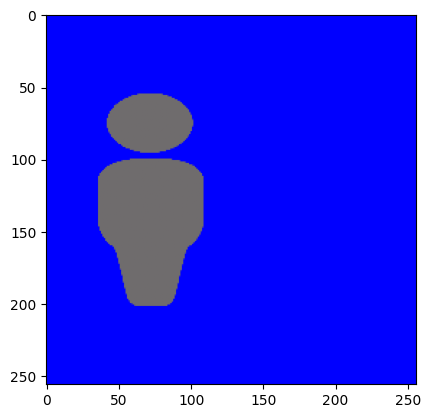

In [4]:
plt.imshow(X[0])

## prepare data
1. resizes images to SIZExSIZE
2. normalizes images to [0,1]

In [5]:
X = [cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X] 
# greyscale
X = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X]
X = np.array(X)
# normalize
X = X / 255.0



print(X.shape, Y.shape)

(292, 16, 16) (292, 1, 4)


[[0.2578125 0.21875   0.2890625 0.578125 ]]
[[0.19140625 0.08203125 0.2890625  0.578125  ]]
[[0.23046875 0.375      0.2890625  0.578125  ]]
[[0.3984375 0.046875  0.2890625 0.578125 ]]
[[0.6171875  0.25390625 0.2890625  0.578125  ]]
[[0.015625   0.18359375 0.2890625  0.578125  ]]


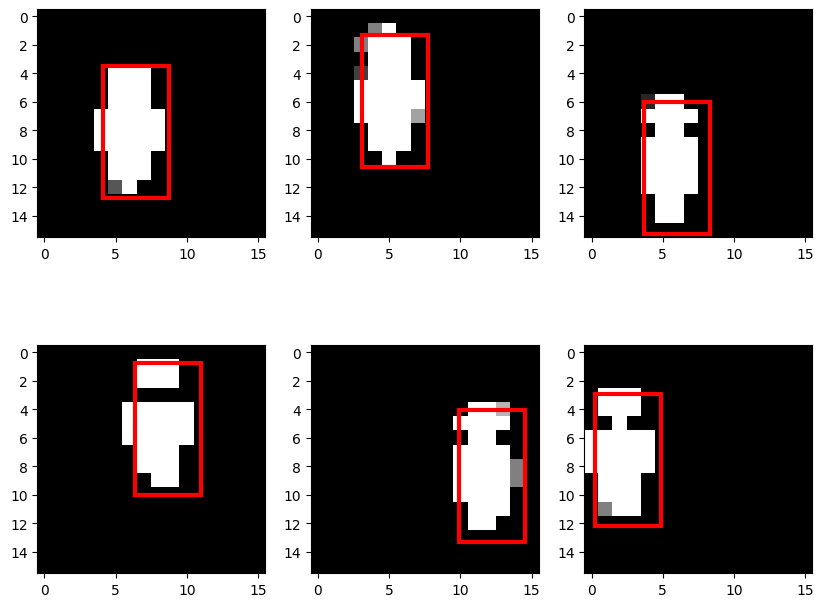

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
images = np.random.choice(X.shape[0], 6)

for i in range(2):
    for j in range(3):
        rect = Y[images[i * 3 + j]]
        print(rect)
        for r in rect:
            x, y, w, h = r
            ax[i, j].add_patch(
                plt.Rectangle(
                    (x * IMG_SIZE, y * IMG_SIZE),
                    w * IMG_SIZE,
                    h * IMG_SIZE,
                    fill=False,
                    edgecolor="red",
                    lw=3,
                )
            )
        ax[i, j].imshow(X[images[i * 3 + j]], cmap="gray")

plt.show()


In [7]:
# split data into train and test
X = X.reshape(X.shape[0], IMG_SIZE, IMG_SIZE ,1)

Y = Y.reshape(Y.shape[0], Y.shape[1] * 4)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape,  X_test.shape, y_train.shape, y_test.shape)


(233, 16, 16, 1) (59, 16, 16, 1) (233, 4) (59, 4)


In [8]:
path = Path("data").resolve()
np.save(path / "X_train.npy", X_train)
np.save(path / "X_test.npy", X_test)
np.save(path / "y_train.npy", y_train)
np.save(path / "y_test.npy", y_test)


In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, MaxPool2D
from tensorflow.keras import layers
# import tf Input
from tensorflow.keras import Input


#import optimizers
from tensorflow.keras.optimizers import Adam


In [10]:
EPOCHS = 200
BATCH_SIZE = 16

In [11]:


nn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    Flatten(),
    Dense(units=2, activation='relu'),
    Dense(units=4)
])

In [12]:
input_layer = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [13]:
model = Model(inputs=input_layer, outputs=locator_branch)
model.compile(loss={"bb_head":tf.keras.losses.MSE}, optimizer='Adam', metrics=['accuracy'])

In [14]:
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/200
15/15 [==============================] - 2s 51ms/step - loss: 0.0491 - accuracy: 0.7897 - val_loss: 0.0400 - val_accuracy: 0.8136
Epoch 2/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0258 - accuracy: 0.8498 - val_loss: 0.0147 - val_accuracy: 0.8136
Epoch 3/200
15/15 [==============================] - 0s 9ms/step - loss: 0.0131 - accuracy: 0.8498 - val_loss: 0.0130 - val_accuracy: 0.8136
Epoch 4/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0130 - accuracy: 0.8498 - val_loss: 0.0131 - val_accuracy: 0.8136
Epoch 5/200
15/15 [==============================] - 0s 8ms/step - loss: 0.0128 - accuracy: 0.8498 - val_loss: 0.0126 - val_accuracy: 0.8136
Epoch 6/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0129 - accuracy: 0.8498 - val_loss: 0.0128 - val_accuracy: 0.8136
Epoch 7/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0128 - accuracy: 0.8498 - val_loss: 0.0127 - val_accuracy: 0.8136
Epoch 8/200

In [15]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    height_true = y_true[:,3] - y_true[:,1] 
    width_true = y_true[:,2] - y_true[:,0] 

    height_pred = yhat[:,3] - yhat[:,1] 
    width_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(width_true - width_pred) + tf.square(height_true-height_pred))
    
    return delta_coord + delta_size

In [16]:
optimizer = Adam(learning_rate=0.001)
nn.compile(
    optimizer=optimizer,
    loss=localization_loss,
    # callbacks=[]
    )

In [17]:
history = nn.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/200
15/15 [==============================] - 1s 18ms/step - loss: 5.9550 - val_loss: 5.8123
Epoch 2/200
15/15 [==============================] - 0s 6ms/step - loss: 5.4919 - val_loss: 5.3699
Epoch 3/200
15/15 [==============================] - 0s 5ms/step - loss: 5.1133 - val_loss: 5.0145
Epoch 4/200
15/15 [==============================] - 0s 5ms/step - loss: 4.8103 - val_loss: 4.7066
Epoch 5/200
15/15 [==============================] - 0s 4ms/step - loss: 4.5692 - val_loss: 4.6033
Epoch 6/200
15/15 [==============================] - 0s 5ms/step - loss: 4.3612 - val_loss: 4.1534
Epoch 7/200
15/15 [==============================] - 0s 5ms/step - loss: 4.1161 - val_loss: 4.0154
Epoch 8/200
15/15 [==============================] - 0s 6ms/step - loss: 3.9394 - val_loss: 3.7876
Epoch 9/200
15/15 [==============================] - 0s 6ms/step - loss: 3.7489 - val_loss: 3.5763
Epoch 10/200
15/15 [==============================] - 0s 5ms/step - loss: 3.5778 - val_loss: 3.4094
Epoch 11

<AxesSubplot: >

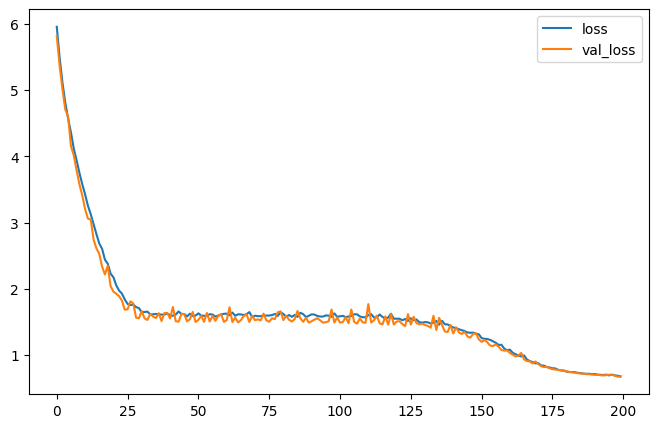

In [18]:
# plot the training loss and accurac
pd.DataFrame(history.history).plot(figsize=(8, 5))


1/1 [==============================] - 0s 85ms/step
[[0.44 0.25 0.25 0.63]]
1/1 [==============================] - 0s 23ms/step
[[0.39 0.22 0.28 0.59]]
1/1 [==============================] - 0s 23ms/step
[[0.49 0.27 0.23 0.66]]
1/1 [==============================] - 0s 30ms/step
[[0.32 0.19 0.31 0.55]]
1/1 [==============================] - 0s 22ms/step
[[0.46 0.26 0.24 0.64]]
1/1 [==============================] - 0s 23ms/step
[[0.16 0.11 0.38 0.44]]


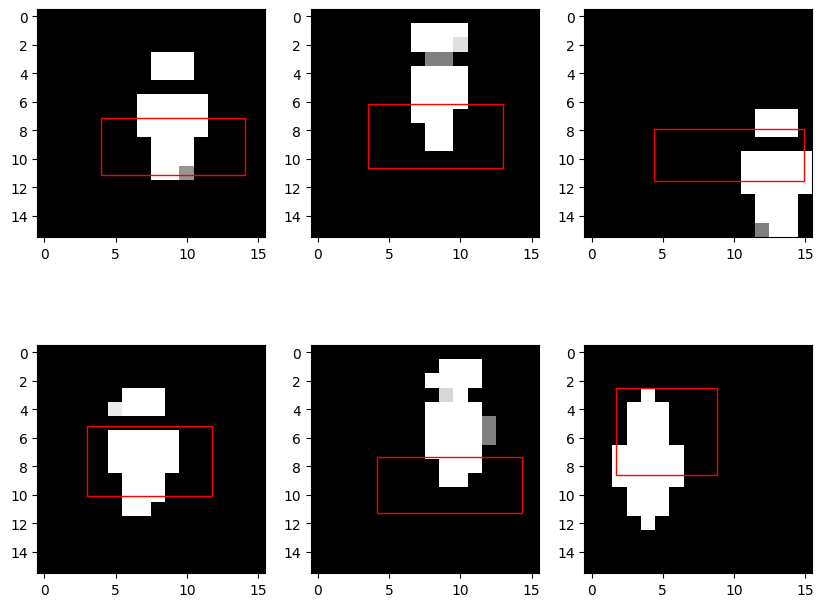

In [19]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
images = np.random.choice(X.shape[0], 6)

for i in range(2):
    for j in range(3):
        index = np.random.randint(0, X_test.shape[0])
        y_pred = nn.predict(X[index].reshape(-1, IMG_SIZE, IMG_SIZE, 1))
        rect = y_pred.reshape(-1, 4)
        print(np.around(rect, 2))
        ax[i, j].add_patch(
            plt.Rectangle(
                (rect[0][1] * IMG_SIZE, rect[0][0] * IMG_SIZE),
                rect[0][3] * IMG_SIZE,
                rect[0][2] * IMG_SIZE,
                fill=False,
                color="red",
            )
        )
        ax[i, j].imshow(X[index].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")

plt.show()
